# 1. MF with Keras

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,Dot,Add,Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD,Adamax

r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv('u.data',
                      names=r_cols,
                      sep='\t',
                      encoding='latin-1')

ratings_train,ratings_test = train_test_split(ratings,
                                              test_size=0.2,
                                              shuffle=True,
                                              random_state=2021)

In [21]:
K = 200

mu = ratings_train.rating.mean()

M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

def RMSE(y_true ,y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

In [22]:
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

In [23]:
R = layers.dot([P_embedding,Q_embedding],axes=(2,2))

R = layers.add([R,user_bias,item_bias])

R = Flatten()(R)

model = Model(inputs=[user,item],outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 1, 200)    │    188,800 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 1, 200)    │    336,600 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1, 1)      │          0 │ embedding_8[0][0… │
│                     │                   │            │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 1)      │        944 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 1)      │      1,683 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 1)      │          0 │ dot_2[0][0],      │
│                     │                   │            │ embedding_10[0][… │
│                     │                   │            │ embedding_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ add_2[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 528,027 (2.01 MB)

 Trainable params: 528,027 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
result = model.fit(
    x = [
        ratings_train.user_id.values,
         ratings_train.movie_id.values
    ],
    y = ratings_train.rating.values - mu,

    epochs = 60,
    batch_size = 256,
    validation_data = (
        [
            ratings_test.user_id.values,
            ratings_test.movie_id.values
        ],
         ratings_test.rating.values - mu
    )
)

Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3796 - rmse: 1.1261 - val_loss: 4.9883 - val_rmse: 1.1191
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8784 - rmse: 1.1277 - val_loss: 4.5308 - val_rmse: 1.1190
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4313 - rmse: 1.1241 - val_loss: 4.1272 - val_rmse: 1.1190
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0413 - rmse: 1.1254 - val_loss: 3.7712 - val_rmse: 1.1190
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6938 - rmse: 1.1231 - val_loss: 3.4570 - val_rmse: 1.1189
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3919 - rmse: 1.1260 - val_loss: 3.1799 - val_rmse: 1.1190
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1220 - rmse: 1.1248 - val_loss: 2.9354 - val_rmse: 1.1190
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8856 - rmse: 1.1256 - val_loss: 2.7197 - val_rmse: 1.1190
Epoch 9/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 

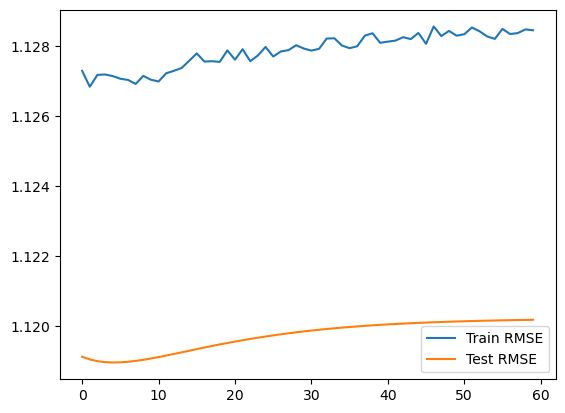

In [25]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['rmse'],label="Train RMSE")
plt.plot(result.history['val_rmse'],label='Test RMSE')
plt.legend()
plt.show()

In [26]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids,movie_ids]) + mu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [27]:
print(ratings_test[0:6])

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [28]:
print(predictions)

[[3.5556355]
 [3.472447 ]
 [3.5513484]
 [3.5689738]
 [3.1887634]
 [3.5953937]]


In [29]:
import numpy as np

def RMSE2(y_true,y_pred):
  return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

In [30]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids,movie_ids]) + mu

y_pred = np.ravel(y_pred,order='C')

y_true = np.array(ratings_test.rating)

RMSE2(y_true,y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


1.0913874740651548